In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### 수정 버전 v 0.1.0

- efficient_net + augmentation

- 어느정도 과적합 같음(f-1스코어의 차이가 어느정도 남), 때문에 k-fold가 필요하지 않을까
- efficientnet과 앙상블cnn할 모델 필요할거같음(beit)
- cnn2rnn을 유지 할것인가? rnn을 버리고 cnn만 이용해도 큰 차이가 없을거같음


# 사용 패키지

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json 
import torch
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from albumentations import Compose, Resize, CLAHE, RandomBrightnessContrast, ColorJitter, RGBShift, RandomSnow, RandomResizedCrop, ShiftScaleRotate, HorizontalFlip, VerticalFlip, Rotate, RandomRotate90, Normalize
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset


# 데이터 살펴보기

In [3]:
sample = glob('data/train/train/*')[42]

sample_csv = pd.read_csv(glob(sample+'/*.csv')[0])
sample_image = cv2.imread(glob(sample+'/*.jpg')[0])
sample_json = json.load(open(glob(sample+'/*.json')[0], 'r'))

In [4]:
# csv
sample_csv

,측정시각,내부 온도 1 평균,내부 온도 1 최고,내부 온도 1 최저,내부 온도 2 평균,내부 온도 2 최고,내부 온도 2 최저,내부 온도 3 평균,내부 온도 3 최고,내부 온도 3 최저,...,배지 중량 최저,양액 온도 평균,양액 온도 최고,양액 온도 최저,외부 풍향 수치,외부 풍향,외부 빗물 시간,외부 누적일사 평균,양액 급액 누적,양액 배액 누적
0,2021-10-13 20:20:00,20.7,21.5,20.5,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
1,2021-10-13 20:10:00,20.9,21.5,20.5,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
2,2021-10-13 20:00:00,21.0,21.5,20.5,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
3,2021-10-13 19:50:00,20.9,21.5,20.4,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
4,2021-10-13 19:40:00,21.0,21.5,20.5,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,2021-10-12 10:50:00,19.9,20.7,19.3,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
202,2021-10-12 10:40:00,19.7,20.7,19.3,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
203,2021-10-12 10:30:00,20.0,20.6,19.3,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
204,2021-10-12 10:20:00,19.7,20.5,19.3,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


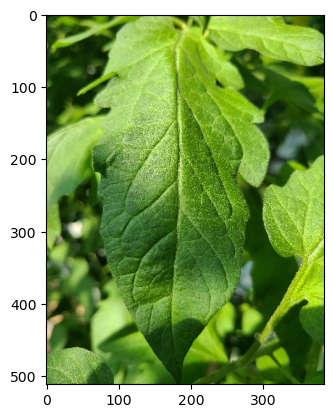

In [5]:
# image
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
# json
sample_json

{'description': {'date': '20211014',
  'image': '10519.jpg',
  'task': 0,
  'width': 384,
  'time': '1105',
  'region': 0,
  'height': 512},
 'annotations': {'area': 3,
  'disease': '00',
  'grow': 13,
  'bbox': [{'x': 42.857142857142854,
    'h': 512.0,
    'y': 0.0,
    'w': 266.7261904761905}],
  'part': [],
  'risk': 0,
  'crop': 2}}

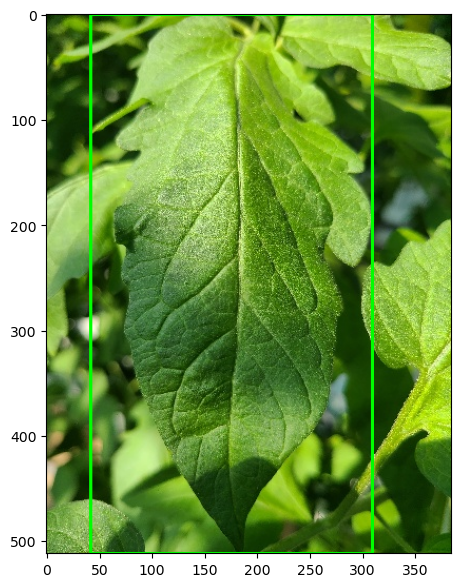

In [7]:
# visualize bbox
plt.figure(figsize=(7,7))
points = sample_json['annotations']['bbox'][0]
part_points = sample_json['annotations']['part']
img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

cv2.rectangle(
    img,
    (int(points['x']), int(points['y'])),
    (int((points['x']+points['w'])), int((points['y']+points['h']))),
    (0, 255, 0),
    2
)
for part_point in part_points:
    point = part_point
    cv2.rectangle(
        img,
        (int(point['x']), int(point['y'])),
        (int((point['x']+point['w'])), int((point['y']+point['h']))),
        (255, 0, 0),
        1
    )
plt.imshow(img)
plt.show()

# 데이터 로드

## 환경 데이터 통계량 계산 for MinMax Scaling

In [8]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

csv_files = sorted(glob('data/train/train/*/*.csv'))

temp_csv = pd.read_csv(csv_files[0])[csv_features]
max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()

# feature 별 최대값, 최솟값 계산
for csv in tqdm(csv_files[1:]):
    
    temp_csv = pd.read_csv(csv)[csv_features]
    temp_csv = temp_csv.replace('-',np.nan).dropna()
    if len(temp_csv) == 0:
        continue
    temp_csv = temp_csv.astype(float)
    temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
    max_arr = np.max([max_arr,temp_max], axis=0)
    min_arr = np.min([min_arr,temp_min], axis=0)

# feature 별 최대값, 최솟값 dictionary 생성
csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}
csv_feature_dict

100%|██████████| 5766/5766 [01:29<00:00, 64.72it/s]


{'내부 온도 1 평균': [3.4, 47.3],
 '내부 온도 1 최고': [3.4, 47.6],
 '내부 온도 1 최저': [3.3, 47.0],
 '내부 습도 1 평균': [23.7, 100.0],
 '내부 습도 1 최고': [25.9, 100.0],
 '내부 습도 1 최저': [0.0, 100.0],
 '내부 이슬점 평균': [0.1, 34.5],
 '내부 이슬점 최고': [0.2, 34.7],
 '내부 이슬점 최저': [0.0, 34.4]}

## CustomDataset 제작

In [9]:
# 변수 설명 csv 파일 참조
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
disease = {
        '1': {
            'a1': '딸기잿빛곰팡이병 - 확산되지 않도록 꽃과 과실을 제거 후, 벤지미다졸 계열 약제를 살포 후 습도 및 환기에 유의해주세요', 
            'a2': '딸기흰가루병 - 일조량을 높여주고, 유황계 살균제를 살포해주세요',
            'b1': '냉해피해 - 온실 내부 온도를 유지해주세요', 
            'b6': '다량원소결핍 (N) - 질소 함유 비료를 추가해주세요',
            'b7': '다량원소결핍 (P) - 인 함유 비료를 추가해주세요',
            'b8': '다량원소결핍 (K) - 칼륨 함유 비료를 추가해주세요'
        },
        '2': {
            'a5': '토마토흰가루병 - 확산되지 않도록 감염 부위를 제거하고, 유황계 약제를 살포 후 습도를 조절해주세요', 
            'a6': '토마토잿빛곰팡이병 - 감염부위를 제거하고, 일조량을 높인 후 벤지미다졸 계열 살균제를 살포해주세요', 
            'b2': '열과 - 온실 내부 온도를 유지해주세요', 
            'b3': '칼슘결핍 - 칼슘 함유 비료를 추가해주세요',
            'b6': '다량원소결핍 (N) - 질소 함유 비료를 추가해주세요',
            'b7': '다량원소결핍 (P) - 인 함유 비료를 추가해주세요', 
            'b8': '다량원소결핍 (K) - 칼륨 함유 비료를 추가해주세요'
        },
        '3': {
            'a9': '파프리카흰가루병 - 감염부위를 제거하고 유황계 살균제를 사용 후 습도관리를 해주세요', 
            'a10': '파프리카잘록병 - 감염부위를 제거 후 다진계 살균제를 사용 후 물을 관리해주세요', 
            'b3': '칼슘결핍 - 칼슘 함유 비료를 추가해주세요', 
            'b6': '다량원소결핍 (N) - 질소 함유 비료를 추가해주세요', 
            'b7': '다량원소결핍 (P) - 인 함유 비료를 추가해주세요', 
            'b8': '다량원소결핍 (K) - 칼륨 함유 비료를 추가해주세요'
        },
        '4': {
            'a3': '오이노균병 - 에타브론, 메타락실등 살균제를 사용하고 감염부위를 제거해주세요', 
            'a4': '오이흰가루병 - 유황계 살균제를 사용 후 감염부위를 제거하고 환기를 자주 시켜주세요', 
            'b1': '냉해피해 - 온실 내부 온도를 유지해주세요', 
            'b6': '다량원소결핍 (N) - 질소 함유 비료를 추가해주세요', 
            'b7': '다량원소결핍 (P) - 인 함유 비료를 추가해주세요', 
            'b8': '다량원소결핍 (K) - 칼륨 함유 비료를 추가해주세요' 
        },
        '5': {
            'a7': '고추탄저병 - 아졸계 살균제를 이용하여 살균하고 감염부위를 제거 후 환기 개선 및 습도 관리를 해주세요', 
            'a8': '고추흰가루병 - 유황계 살균제를 사용 후 감염부위를 제거 후 적절한 간격으로 물을 주고 습도를 조절해주세요', 
            'b3': '칼슘결핍 - 칼슘 함유 비료를 추가해주세요', 
            'b6': '다량원소결핍 (N) - 질소 함유 비료를 추가해주세요', 
            'b7': '다량원소결핍 (P) - 인 함유 비료를 추가해주세요', 
            'b8': '다량원소결핍 (K) - 칼륨 함유 비료를 추가해주세요'
        },
        '6': {'a11': '시설포도탄저병 - 아졸계 살균제를 사용 후 감염 부위를 제거하고 환기 및 습도 조절을 해주세요', 
              'a12': '시설포도노균병 - 포스틸 알루미늄 살균제를 사용하고 감염 부위 제거 후 적절한 간격으로 물과 습도를 조절해주세요', 
              'b4': '일소피해 - 차광막을 설치하고 피해 부위를 제거해주세요', 
              'b5': '축과병 -  적절한 물과 배수 관리를 해주고 피해 부위를 제거해주세요'}
    }
risk = {'1':'초기','2':'중기','3':'말기'}

In [10]:
'''# 변수 설명 csv 파일 참조
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}
risk = {'1':'초기','2':'중기','3':'말기'}'''

"# 변수 설명 csv 파일 참조\ncrop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}\ndisease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},\n           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},\n           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},\n           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},\n           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},\n           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}\nrisk = {'1':'초기','2':'중기','3':'말기'}"

In [28]:
label_description = {}
for key, value in disease.items():
    label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
    for disease_code in value:
        for risk_code in risk:
            label = f'{key}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'
list(label_description.items())[:10]

print(len(csv_feature_dict))
print(len(label_decoder))
print(len(label_encoder))

9
111
111


In [29]:
label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}
print(label_encoder)
print(len(label_decoder))
print(len(label_encoder))

{'1_00_0': 0, '1_a1_1': 1, '1_a1_2': 2, '1_a1_3': 3, '1_a2_1': 4, '1_a2_2': 5, '1_a2_3': 6, '1_b1_1': 7, '1_b1_2': 8, '1_b1_3': 9, '1_b6_1': 10, '1_b6_2': 11, '1_b6_3': 12, '1_b7_1': 13, '1_b7_2': 14, '1_b7_3': 15, '1_b8_1': 16, '1_b8_2': 17, '1_b8_3': 18, '2_00_0': 19, '2_a5_1': 20, '2_a5_2': 21, '2_a5_3': 22, '2_a6_1': 23, '2_a6_2': 24, '2_a6_3': 25, '2_b2_1': 26, '2_b2_2': 27, '2_b2_3': 28, '2_b3_1': 29, '2_b3_2': 30, '2_b3_3': 31, '2_b6_1': 32, '2_b6_2': 33, '2_b6_3': 34, '2_b7_1': 35, '2_b7_2': 36, '2_b7_3': 37, '2_b8_1': 38, '2_b8_2': 39, '2_b8_3': 40, '3_00_0': 41, '3_a9_1': 42, '3_a9_2': 43, '3_a9_3': 44, '3_a10_1': 45, '3_a10_2': 46, '3_a10_3': 47, '3_b3_1': 48, '3_b3_2': 49, '3_b3_3': 50, '3_b6_1': 51, '3_b6_2': 52, '3_b6_3': 53, '3_b7_1': 54, '3_b7_2': 55, '3_b7_3': 56, '3_b8_1': 57, '3_b8_2': 58, '3_b8_3': 59, '4_00_0': 60, '4_a3_1': 61, '4_a3_2': 62, '4_a3_3': 63, '4_a4_1': 64, '4_a4_2': 65, '4_a4_3': 66, '4_b1_1': 67, '4_b1_2': 68, '4_b1_3': 69, '4_b6_1': 70, '4_b6_2': 71

In [13]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train', csv_feature_dict=None, label_encoder=None, transform=None):
        self.mode = mode
        self.files = files
        self.csv_feature_dict = csv_feature_dict
        self.csv_feature_check = [0]*len(self.files)
        self.csv_features = [None]*len(self.files)
        self.max_len = 24 * 6
        self.label_encoder = label_encoder
        self.transform  = transform

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('/')[-1]
        
        # csv
        if self.csv_feature_check[i] == 0:
            csv_path = f'{file}/{file_name}.csv'
            df = pd.read_csv(csv_path)[self.csv_feature_dict.keys()]
            df = df.replace('-', 0)
            # MinMax scaling
            for col in df.columns:
                df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
                df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
            # zero padding
            pad = np.zeros((self.max_len, len(df.columns)))
            length = min(self.max_len, len(df))
            pad[-length:] = df.to_numpy()[-length:]
            # transpose to sequential data
            csv_feature = pad.T
            self.csv_features[i] = csv_feature
            self.csv_feature_check[i] = 1
        else:
            csv_feature = self.csv_features[i]
        
        # image
        image_path = f'{file}/{file_name}.jpg'
        img = cv2.imread(image_path)
        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32)/255
        img = np.transpose(img,(2,0,1))
        
        
        
        
        if self.mode in ['train', 'val']:                   
            json_path = f'{file}/{file_name}.json'
            with open(json_path, 'r') as f:
                json_file = json.load(f)
            
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'

            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
                
            }
        else:
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                
            }
        
        

        





In [14]:
# 이미지 증강 함수 정의
def get_train_transforms(height: int, width: int):
    return Compose([
        CLAHE(p=0.2),
        RandomBrightnessContrast(p=0.2),
        ColorJitter(p=0.2),
        RGBShift(p=0.2),
        RandomSnow(p=0.2),
        RandomResizedCrop(height=height, width=width, p=0.4),
        ShiftScaleRotate(scale_limit=0.2, rotate_limit=10, p=0.4),
        HorizontalFlip(p=0.2),
        VerticalFlip(p=0.2),
        Rotate(p=0.2),
        RandomRotate90(p=0.2),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

# 하이퍼파라미터 및 변수

In [15]:
device = torch.device("cuda:0")
batch_size = 256
class_n = len(label_encoder)
learning_rate = 1e-4
embedding_dim = 512
num_features = len(csv_feature_dict)
max_len = 24*6
dropout_rate = 0.1
epochs = 30
vision_pretrain = True
save_path = 'best_model.pt'

# 데이터셋 구성

In [16]:
train = sorted(glob('data/train/train/*'))
test = sorted(glob('data/test/test/*'))

labelsss = pd.read_csv('data/train.csv')['label']
train, val = train_test_split(train, test_size=0.2, stratify=labelsss)

In [30]:
print(len(train))

4613


In [18]:
'''# 데이터로더 설정
train_dataset = CustomDataset(train)
val_dataset = CustomDataset(val)
test_dataset = CustomDataset(test, mode = 'test')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=16, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=16, shuffle=False)'''

# CSV feature dictionary와 label encoder를 설정합니다.
# 데이터 전처리 및 변환 설정
train_transforms = get_train_transforms(height=256, width=256)

val_transforms = Compose([
    Resize(height=256, width=256),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# 데이터셋 설정
train_dataset = CustomDataset(train, mode='train', csv_feature_dict=csv_feature_dict, label_encoder=label_encoder, transform=train_transforms)
val_dataset = CustomDataset(val, mode='val', csv_feature_dict=csv_feature_dict, label_encoder=label_encoder, transform=val_transforms)
test_dataset = CustomDataset(test, mode='test', csv_feature_dict=csv_feature_dict, label_encoder=label_encoder, transform=val_transforms)

# 데이터 로더 설정
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=16)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16)




print(len(train_dataloader))
print(len(val_dataloader))



19
5


# 모델

## 이미지 분류 모델 : efficientnet
### efficientnet_b0



In [19]:
class CNN_Encoder(nn.Module):
    def __init__(self, class_n, rate=0.1):
        super(CNN_Encoder, self).__init__()
        self.model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    
    def forward(self, inputs):
        output = self.model(inputs)
        return output

## 시계열 모델 : LSTM

In [20]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(RNN_Decoder, self).__init__()
        self.lstm = nn.LSTM(max_len, embedding_dim)
        self.rnn_fc = nn.Linear(num_features * embedding_dim, 1000)
        self.final_layer = nn.Linear(1000 + 1000, class_n) # resnet out_dim + lstm out_dim
        self.dropout = nn.Dropout(rate)

    def forward(self, enc_out, dec_inp):
        hidden, _ = self.lstm(dec_inp)
        hidden = hidden.view(hidden.size(0), -1)
        hidden = self.rnn_fc(hidden)
        concat = torch.cat([enc_out, hidden], dim=1) # enc_out + hidden 
        fc_input = concat
        output = self.dropout(self.final_layer(fc_input))
        return output

## 앙상블

In [21]:
class CNN2RNN(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_features, class_n, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        return output


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model = model.to(device)

In [23]:
print(train_dataloader)


# 학습

In [24]:
print(label)

6_b5_3


In [25]:
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
import torch
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score  # f1_score import 추가

# Optimizer와 Loss Function 설정
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Accuracy function 정의
def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score

# Training step 정의
def train_step(batch_item, training):
    img = batch_item['img'].to(device)
    csv_feature = batch_item['csv_feature'].to(device)
    label = batch_item['label'].to(device)
    
    if training:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            output = model(img, csv_feature)
            loss = criterion(output, label)
    
    score = accuracy_function(label, output)
    return loss, score

# Training 및 Validation loop 정의
loss_plot, val_loss_plot = [], []
metric_plot, val_metric_plot = [], []

for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0
    
    # Training loop
    tqdm_dataset = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training=True)
        total_loss += batch_loss
        total_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Loss': '{:06f}'.format(total_loss / (batch + 1)),
            'Mean F-1': '{:06f}'.format(total_acc / (batch + 1))
        })
    loss_plot.append(total_loss / (batch + 1))
    metric_plot.append(total_acc / (batch + 1))
    
    # Validation loop
    tqdm_dataset = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training=False)
        total_val_loss += batch_loss
        total_val_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Val Loss': '{:06f}'.format(total_val_loss / (batch + 1)),
            'Mean Val F-1': '{:06f}'.format(total_val_acc / (batch + 1))
        })
    val_loss_plot.append(total_val_loss / (batch + 1))
    val_metric_plot.append(total_val_acc / (batch + 1))
    
    if np.max(val_metric_plot) == val_metric_plot[-1]:
        torch.save(model.state_dict(), save_path)


  0%|          | 0/19 [00:12<?, ?it/s]


KeyboardInterrupt: 

### 결과 그래프


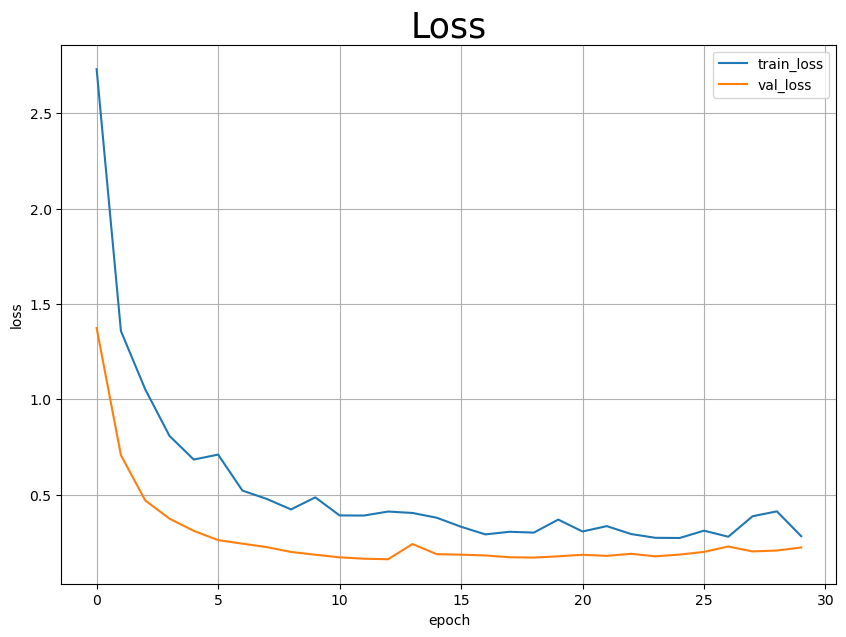

In [ ]:
plt.figure(figsize=(10,7))
plt.grid()
plt.plot([loss.detach().cpu().numpy() for loss in loss_plot], label='train_loss')
plt.plot([val_loss.detach().cpu().numpy() for val_loss in val_loss_plot], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss", fontsize=25)
plt.legend()
plt.show()

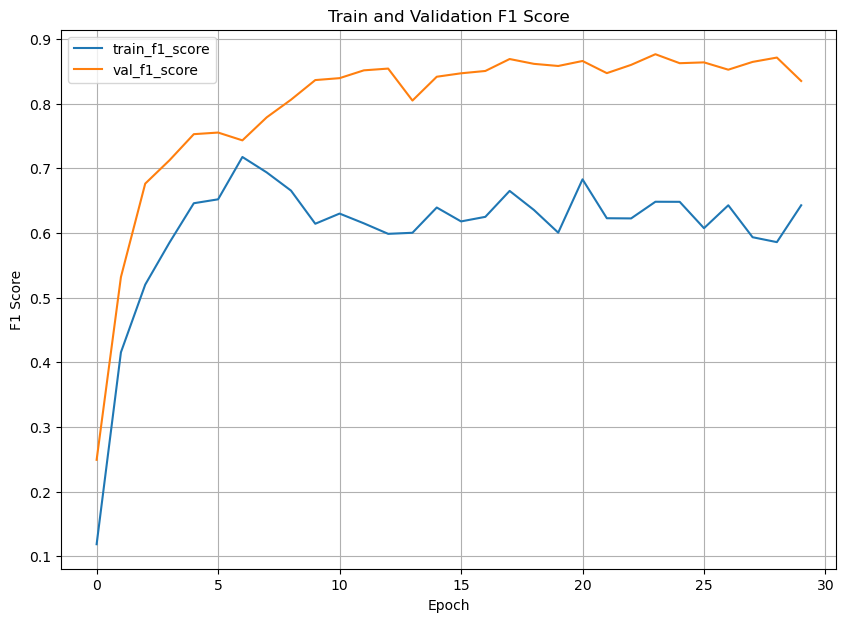

In [ ]:
# F1 점수 그래프
plt.figure(figsize=(10, 7))
plt.grid()
plt.plot(metric_plot, label='train_f1_score')
plt.plot(val_metric_plot, label='val_f1_score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Train and Validation F1 Score')
plt.show()

# 추론

In [ ]:
def predict(dataset):
    model.eval()
    tqdm_dataset = tqdm(enumerate(dataset))
    results = []
    for batch, batch_item in tqdm_dataset:
        img = batch_item['img'].to(device)
        seq = batch_item['csv_feature'].to(device)
        with torch.no_grad():
            output = model(img, seq)
        output = torch.argmax(output, dim=1).clone().detach().cpu().numpy()
        results.extend(output)
    return results

model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)

preds = predict(test_dataloader)

203it [16:00,  4.73s/it]


In [ ]:
preds = np.array([label_decoder[int(val)] for val in preds])

KeyError: 6000

# 제출 파일 생성

In [ ]:
submission = pd.read_csv('data/sample_submission.csv')
submission['label'] = preds
submission

,image,label
0,10000,6_00_0
1,10001,5_b6_1
2,10002,4_00_0
3,10003,3_00_0
4,10004,3_b8_1
...,...,...
51901,67673,4_00_0
51902,67674,3_b7_1
51903,67675,6_00_0
51904,67676,2_a5_2


In [ ]:
submission.to_csv('baseline_submission.csv', index=False)